In [1]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import timeit
import time

class FlowData:
    def __init__(self, capacity, flow=None, residual=None):
        self.capacity = capacity
        self.flow = flow
        self.residual = residual


class Vertex:
    def __init__(self, key, data, color):
        self.key = key
        self.data = data
        self.color = color

    def set_color(self, color):
        self.color = color

    def get_color(self):
        return self.color


class Adjacency_list:
    def __init__(self):
        self.graph = dict()
        self.weights = dict()
        self.flow_data = dict()

    def getVertex(self, vertex_id):
        for v in self.graph:
            if v.key == vertex_id:
                return v
        return None

    def insertVertex(self, vertex_id, color=None, data=None):
        self.graph[Vertex(vertex_id, data, color)] = []

    def insertEdge(self, vertex1_id, vertex2_id, weight, is_undirected=True):
        node1 = self.getVertex(vertex1_id)
        node2 = self.getVertex(vertex2_id)
        if node1 is None or node2 is None:
            raise ValueError
        self.graph[node1].append(vertex2_id)
        self.weights[(vertex1_id, vertex2_id)] = weight
        self.flow_data[(vertex1_id, vertex2_id, 1)] = FlowData(weight, 0, weight)
        if is_undirected:
            #self.graph[node2].append(vertex1_id)
            self.weights[(vertex2_id, vertex1_id)] = weight
            self.flow_data[(vertex2_id, vertex1_id, 0)] = FlowData(0, 0, 0)

    def create_flow(self, data):
        v1, v2, capacity = data
        node1 = self.getVertex(v1)
        node2 = self.getVertex(v2)
        if node1 is None:
            self.insertVertex(v1)
        if node2 is None:
            self.insertVertex(v2)
        self.insertEdge(v1, v2, capacity)

    def deleteVertex(self, vertex_id, is_undirected=True):
        node = self.getVertex(vertex_id)
        if node is None:
            raise KeyError
        for node_nr in self.graph[node]:
            del self.weights[(node.key, node_nr)]
            del self.flow_data[(node.key, node_nr, 1)]
            if is_undirected:
                del self.weights[(node_nr, node.key)]
                del self.flow_data[(node_nr, node.key, 0)]
        del self.graph[node]
        for val in self.graph.values():
            if vertex_id in val:
                val.remove(vertex_id)

    def deleteEdge(self, vertex1_id, vertex2_id, is_undirected=True):
        node1 = self.getVertex(vertex1_id)
        node2 = self.getVertex(vertex2_id)
        if node1 is None or node2 is None:
            raise KeyError
        self.graph[node1].remove(vertex2_id)
        del self.weights[(vertex1_id, vertex2_id)]
        del self.flow_data[(vertex1_id, vertex2_id, 1)]
        if is_undirected:
            if vertex1_id in self.graph[node2]:
                self.graph[node2].remove(vertex1_id)
            del self.weights[(vertex2_id, vertex1_id)]
            del self.flow_data[(vertex2_id, vertex1_id, 0)]

    def neighbours(self, vertex_id):
        node = self.getVertex(vertex_id)
        if node is None:
            raise KeyError
        return self.graph[node]

    def neighbours_wor(self, vertex_id):
        nb_lst = []
        node = self.getVertex(vertex_id)
        if node is None:
            raise KeyError
        for nb in self.graph[node]:
            nb_lst.append(nb)
        return nb_lst

    def set_color(self, vertex_id, color):
        node = self.getVertex(vertex_id)
        node.set_color(color)

    def get_color(self, vertex_id):
        node = self.getVertex(vertex_id)
        return node.get_color()

    def order(self):
        return len(self.graph)

    def size(self):
        gsize = 0
        for val in self.graph.values():
            gsize += len(val)
        return gsize

    def edges(self):
        lst_of_edges = []
        for keys, nb in self.graph.items():
            for u in nb:
                lst_of_edges.append((keys.key, u))
        return lst_of_edges

    def vertex_edges(self, vertex_id):
        node = self.getVertex(vertex_id)
        lst_of_edges = []
        for node_nr in self.graph[node]:
            lst_of_edges.append((vertex_id, node_nr))
        return lst_of_edges

    def edges_to_vertex(self, vertex_id):
        lst_of_edges = []
        for node, nb_lst in self.graph.items():
            for elem in nb_lst:
                if elem == vertex_id:
                    lst_of_edges.append((node.key, elem, 1))
        return lst_of_edges
    
    def flow_edges(self):
        lst_of_edges = []
        for node in self.graph:
            for nb in self.graph[node]:
                edge = (node.key, nb, 1)
                f_data = self.flow_data[edge]
                lst_of_edges.append((edge, f_data.flow, f_data.capacity, f_data.residual))
        return lst_of_edges

    def keys_tuples(self):
        lst = []
        for vertex in self.graph:
            lst.append((vertex.key, vertex.key))
        return lst

    def prim_mst(self):
        start = random.choice(list(self.graph.keys()))
        n = len(self.graph)
        labels = [elem for elem in self.graph]
        total_dist = 0

        intree = [0 for _ in range(n)]
        distance = [float('inf') for _ in range(n)]
        parent = [-1 for _ in range(n)]

        T_prim = Adjacency_list()
        for vertex in self.graph:
            T_prim.insertVertex(vertex.key, vertex.color, vertex.data)

        v: Vertex = start
        v_idx = labels.index(v)
        distance[v_idx] = 0

        while intree[labels.index(v)] == 0:
            v_idx = labels.index(v)
            intree[v_idx] = 1
            for u in self.graph[v]:
                u_idx = labels.index(self.getVertex(u))
                if intree[u_idx] == 0:
                    if self.weights[(v.key, u)] < distance[u_idx]:
                        distance[u_idx] = self.weights[(v.key, u)]
                        parent[u_idx] = v.key
            not_visited_dist_label = []
            for vertex in self.graph:
                vertex_idx = labels.index(vertex)
                if intree[vertex_idx] == 0:
                    not_visited_dist_label.append((distance[vertex_idx], vertex_idx))
            if not_visited_dist_label:
                min_val = min(not_visited_dist_label)
                min_idx = min_val[1]
                v = labels[min_idx]
                T_prim.insertEdge(parent[min_idx], v.key, self.weights[(parent[min_idx], v.key)])
                total_dist += self.weights[(parent[min_idx], v.key)]
        return T_prim

    def BFS(self, start=None):
        if start is None:
            start = random.choice(list(self.graph.keys()))
        visited = [start.key]
        parents = []
        queue = [start.key]
        loops = 0
        while queue:
            loops += 1
            vertex = queue.pop(0)
            for nb in self.neighbours_wor(vertex):
                if nb not in visited and self.flow_data[(vertex, nb, 1)].residual > 0:
                    queue.append(nb)
                    visited.append(nb)
                    parents.append(vertex)
        print("LOOP: ", loops)
        return parents, visited[1:]

    def flow_calc(self, start, end, parents, visited):
        curr = end
        s_fcapacity = float('inf')

        if end not in visited:
            return 0

        while curr != start:
            next_curr = parents[visited.index(curr)]
            if self.flow_data[(next_curr, curr, 1)].residual < s_fcapacity:
                s_fcapacity = self.flow_data[(next_curr, curr, 1)].residual
            curr = next_curr
        return s_fcapacity

    def augmentation(self, start, end, parents, s_fcapacity, visited):
        curr = end

        while curr != start:
            next_curr = parents[visited.index(curr)]
            self.flow_data[(next_curr, curr, 1)].flow += s_fcapacity
            self.flow_data[(next_curr, curr, 1)].residual -= s_fcapacity
            self.flow_data[(curr, next_curr, 0)].flow -= s_fcapacity
            curr = next_curr
    

    def FF_EE(self, start, end):
        total = 0
        parents, visited = self.BFS(self.getVertex(start))
        s_fcapacity = self.flow_calc(start, end, parents, visited)
        while s_fcapacity > 0:
            print("Pętla")
            print("MIN_CAP= ", s_fcapacity)
            print("AUGUment")
            s = time.time()
            self.augmentation(start, end, parents, s_fcapacity, visited)
            e = time.time()
            print("czas: ", e-s)

            print("BFS")
            s = time.time()
            parents, visited = self.BFS(self.getVertex(start))
            e = time.time()
            print("czas: ", e-s)

            print("MIN RES")
            s = time.time()
            s_fcapacity = self.flow_calc(start, end, parents, visited)
            e = time.time()
            print("czas: ", e-s)
            
        sink_edges = self.edges_to_vertex(end)
        for connection in sink_edges:
            total += self.flow_data[connection].flow
        return total
    
    def min_cut(self, start):
        parents, visited = self.BFS(self.getVertex(start))
        min_cut_edges = []
        minimum_cut = 0
        if not parents or not visited:
            nb_list = self.neighbours_wor(start)
            for nb in nb_list:
                minimum_cut += self.flow_data[(start, nb, 1)].flow
                min_cut_edges.append((start, nb, 1))
            return min_cut_edges, minimum_cut
        
        visited = [start] + visited
        for vertex in visited:
            vertex_nb = self.neighbours_wor(vertex)
            for nb in vertex_nb:
                if nb not in visited:
                    minimum_cut += self.flow_data[(vertex, nb, 1)].flow
                    min_cut_edges.append((vertex, nb, 1))
        return min_cut_edges, minimum_cut
                    
            

In [2]:
graf_0 = [('s', 'u', 2), ('u', 't', 1), ('u', 'v', 3), ('s', 'v', 1), ('v', 't', 2)]

graf_1 = [('s', 'a', 16), ('s', 'c', 13), ('a', 'c', 10), ('c', 'a', 4), ('a', 'b', 12), ('b', 'c', 9),
          ('b', 't', 20), ('c', 'd', 14), ('d', 'b', 7), ('d', 't', 4)]

graf_2 = [('s', 'a', 3), ('s', 'c', 3), ('a', 'b', 4), ('b', 's', 3), ('b', 'c', 1), ('b', 'd', 2), ('c', 'e', 6),
          ('c', 'd', 2), ('d', 't', 1), ('e', 't', 9)]

graf_3 = [('s', 'a', 8), ('s', 'd', 3), ('a', 'b', 9), ('b', 'd', 7), ('b', 't', 2), ('c', 't', 5), ('d', 'b', 7),
          ('d', 'c', 4)]

graph_0 = Adjacency_list()
graph_1 = Adjacency_list()
graph_2 = Adjacency_list()
graph_3 = Adjacency_list()

for data0 in graf_0:
    graph_0.create_flow(data0)
for data1 in graf_1:
    graph_1.create_flow(data1)
for data2 in graf_2:
    graph_2.create_flow(data2)
for data3 in graf_3:
    graph_3.create_flow(data3)

print("Wynik dla graf_0 = ", graph_0.FF_EE('s', 't'))
print("Wynik dla graf_1 = ", graph_1.FF_EE('s', 't'))
print("Wynik dla graf_2 = ", graph_2.FF_EE('s', 't'))
print("Wynik dla graf_3 = ", graph_3.FF_EE('s', 't'))

print(graph_0.min_cut('s'))
print("\n")
print(graph_1.min_cut('s'))
print("\n")
print(graph_2.min_cut('s'))
print("\n")
print(graph_3.min_cut('s'))

LOOP:  4
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  4
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  4
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1
czas:  0.0
MIN RES
czas:  0.0
Wynik dla graf_0 =  3
LOOP:  6
Pętla
MIN_CAP=  12
AUGUment
czas:  0.0
BFS
LOOP:  6
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  4
AUGUment
czas:  0.0
BFS
LOOP:  6
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  7
AUGUment
czas:  0.0
BFS
LOOP:  4
czas:  0.0
MIN RES
czas:  0.0
Wynik dla graf_1 =  23
LOOP:  7
Pętla
MIN_CAP=  3
AUGUment
czas:  0.0
BFS
LOOP:  7
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  7
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  4
czas:  0.0
MIN RES
czas:  0.0
Wynik dla graf_2 =  5
LOOP:  6
Pętla
MIN_CAP=  2
AUGUment
czas:  0.0
BFS
LOOP:  6
czas:  0.0
MIN RES
czas:  0.0
Pętla
MIN_CAP=  3
AUGUment
czas:  0.0
BFS
LOOP:  6
czas:  0.0
MIN RES
czas:  0.0
Pętla

In [3]:
I = cv2.imread('min_cut_seg_1.png', cv2.IMREAD_GRAYSCALE)

In [4]:
YY, XX = I.shape

scrible_FG = np.zeros((YY,XX),dtype=np.ubyte)
scrible_FG[100:120, 100:120] = 255

scrible_BG = np.zeros((YY,XX),dtype=np.ubyte)
scrible_BG[0:20, 0:20] = 255


I = cv2.resize(I,(32,32))
scrible_BG = cv2.resize(scrible_BG,(32,32))
scrible_FG = cv2.resize(scrible_FG,(32,32))

In [5]:
hist_FG = cv2.calcHist([I],[0],scrible_FG,[256],[0,256])
hist_FG = hist_FG/sum(hist_FG)

hist_BG = cv2.calcHist([I],[0],scrible_BG,[256],[0,256])
hist_BG = hist_BG/sum(hist_BG)

In [6]:
X, Y = I.shape
tree = Adjacency_list()
idx_mat = np.array([[(i, j) for j in range(Y)] for i in range(X)], dtype=tuple)
tree.insertVertex('s')
tree.insertVertex('t')

for i in range(X):
    for j in range(Y):
        tree.insertVertex((X*j) + i, I[i, j], (i, j))
        
for i in range(1, X - 1):
    for j in range(1, Y - 1):
        win_idx = idx_mat[i-1: i+2, j-1: j+2]
        for coord in win_idx:
            for x, y in coord:
                if (x, y) != (i, j):
                    weight_v = np.exp((-0.5) * np.abs(int(I[x, y]) - int(I[i, j])))
                    tree.insertEdge((X*j) + i, (X*y) + x, weight_v)

In [7]:
for i in range(X):
    for j in range(Y):
        v_id = (X*j) + i
        if scrible_FG[i, j] > 0:
            tree.insertEdge('s', v_id, np.inf)
        elif scrible_BG[i, j] > 0:
            tree.insertEdge('s', v_id, 0)
        else:
            tree.insertEdge('s', v_id, 1)
            
        if scrible_FG[i, j] > 0:
            tree.insertEdge(v_id, 't', 0)
        elif scrible_BG[i, j] > 0:
            tree.insertEdge(v_id, 't', np.inf)
        else:
            tree.insertEdge(v_id, 't', 1)


In [8]:
print(tree.size())
max_flow_tree = tree.FF_EE('s', 't')
print(max_flow_tree)
result_img = np.zeros_like(I)

9248
LOOP:  1026
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0857701301574707
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0857703685760498
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.08478260040283203
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0847928524017334
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0857703685760498
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.08377528190612793
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.08477544784545898
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.08477258682250977
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0839700698852539
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.08377575874328613
MIN RES

In [9]:
parents, visited = tree.BFS(tree.getVertex('s'))
for vertex in visited:
    node = tree.getVertex(vertex)
    result_img[node.data] = 255    

LOOP:  257


Text(0.5, 1.0, 'Wynik')

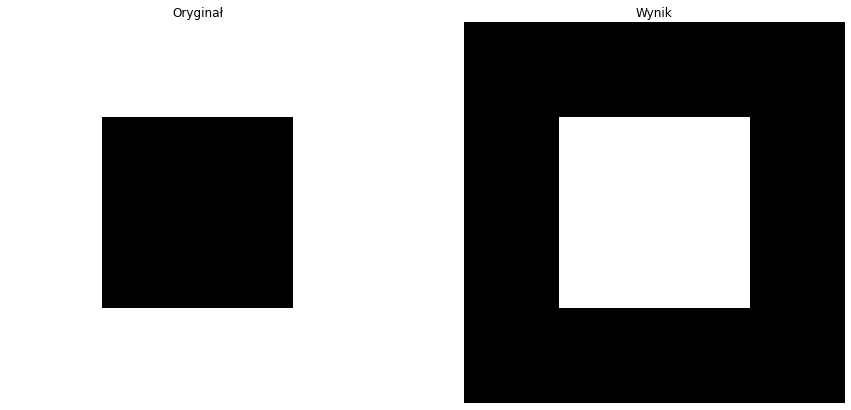

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(I, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Oryginał')
ax[1].imshow(result_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wynik')

    Helikopter

In [11]:
I = cv2.imread('min_cut_seg_2.png', cv2.IMREAD_GRAYSCALE)
YY, XX = I.shape

# korpus smiglowca
scrible_FG = np.zeros((YY,XX),dtype=np.ubyte)
scrible_FG[29:38, 30:43] = 255

# dol i gora obrazka
scrible_BG = np.zeros((YY,XX),dtype=np.ubyte)
scrible_BG[0:10, 0:63] = 255

scrible_BG[50:62, 0:62] = 255


I = cv2.resize(I,(32,32))
scrible_BG = cv2.resize(scrible_BG,(32,32))
scrible_FG = cv2.resize(scrible_FG,(32,32))

In [12]:
hist_FG = cv2.calcHist([I],[0],scrible_FG,[256],[0,256])
hist_FG = hist_FG/sum(hist_FG)

hist_BG = cv2.calcHist([I],[0],scrible_BG,[256],[0,256])
hist_BG = hist_BG/sum(hist_BG)

In [13]:
X, Y = I.shape
tree = Adjacency_list()
idx_mat = np.array([[(i, j) for j in range(Y)] for i in range(X)], dtype=tuple)
tree.insertVertex('s')
tree.insertVertex('t')

for i in range(X):
    for j in range(Y):
        tree.insertVertex((X*j) + i, I[i, j], (i, j))
        
for i in range(1, X - 1):
    for j in range(1, Y - 1):
        win_idx = idx_mat[i-1: i+2, j-1: j+2]
        for coord in win_idx:
            for x, y in coord:
                if (x, y) != (i, j):
                    weight_v = np.exp((-0.5) * np.abs(I[x, y] - I[i, j]))
                    tree.insertEdge((X*j) + i, (X*y) + x, weight_v)


<ipython-input-13-21588110e587>:17: RuntimeWarning: overflow encountered in ubyte_scalars
  weight_v = np.exp((-0.5) * np.abs(I[x, y] - I[i, j]))


In [14]:
for i in range(X):
    for j in range(Y):
        v_id = (X*j) + i
        if scrible_FG[i, j] > 0:
            tree.insertEdge('s', v_id, np.inf)
        elif scrible_BG[i, j] > 0:
            tree.insertEdge('s', v_id, 0)
        else:
            tree.insertEdge('s', v_id, 1)
            
        if scrible_FG[i, j] > 0:
            tree.insertEdge(v_id, 't', 0)
        elif scrible_BG[i, j] > 0:
            tree.insertEdge(v_id, 't', np.inf)
        else:
            tree.insertEdge(v_id, 't', 1)


In [15]:
max_flow_tree = tree.FF_EE('s', 't')
print(max_flow_tree)
result_img = np.zeros_like(I)

LOOP:  1026
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07822227478027344
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.0778191089630127
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07776427268981934
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07598376274108887
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07579874992370605
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07579612731933594
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07682228088378906
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07779169082641602
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07579803466796875
MIN RES
czas:  0.0
Pętla
MIN_CAP=  1
AUGUment
czas:  0.0
BFS
LOOP:  1026
czas:  0.07576847076416016
MIN RES


In [16]:
parents, visited = tree.BFS(tree.getVertex('s'))
for vertex in visited:
    node = tree.getVertex(vertex)
    result_img[node.data] = 255    

LOOP:  66


Text(0.5, 1.0, 'Wynik')

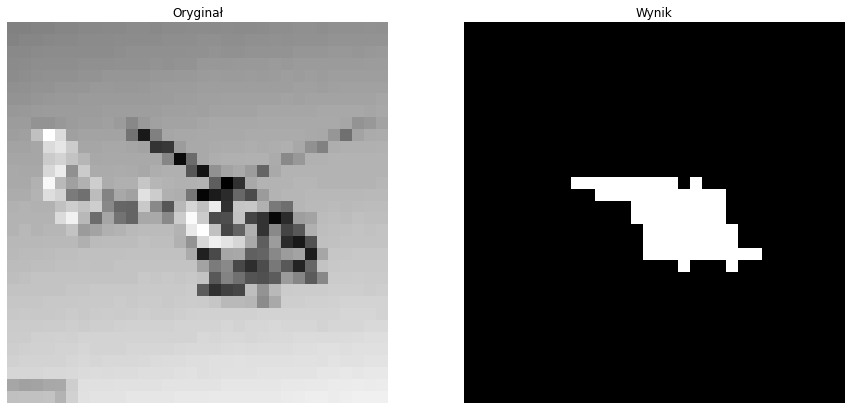

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(I, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Oryginał')
ax[1].imshow(result_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wynik')